In [1]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import numpy as np

import pickle
from collections import namedtuple
from tqdm import tqdm

import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from adabound import AdaBound

import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data_mnist', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.MNIST(root='./data_mnist', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=8)

In [4]:
device = 'cuda:0'

optim_configs = {
    'SGDM': {
        'optimizer': optim.SGD, 
        'kwargs': {
            'lr': 0.01,
            'momentum': 0.9
        }
    },
    'Adam': {
        'optimizer': optim.Adam, 
        'kwargs': {
            'lr': 1e-3,
            'weight_decay': 0,
            'betas': (0.9, 0.999),
            'eps': 1e-08,
            'amsgrad': False
        }
    },
    'AMSGrad': {
        'optimizer': optim.Adam, 
        'kwargs': {
            'lr': 1e-3,
            'weight_decay': 0,
            'betas': (0.9, 0.999),
            'eps': 1e-08,
            'amsgrad': True
        }
    },
    'AdaGrad': {
        'optimizer': optim.Adagrad, 
        'kwargs': {
            'lr': 1e-2,
            'weight_decay': 0,
            'lr_decay': 0,
            'initial_accumulator_value': 0
        }
    },
    'AdaBound': {
        'optimizer': AdaBound, 
        'kwargs': {
            'lr': 1e-3,
            'final_lr': 0.1,
            'weight_decay': 0,
            'betas': (0.9, 0.999),
            'eps': 1e-08,
            'gamma': 1e-3,
            'amsbound': False
        }
    },
    'AMSBound': {
        'optimizer': AdaBound, 
        'kwargs': {
            'lr': 1e-3,
            'final_lr': 0.1,
            'weight_decay': 0,
            'betas': (0.9, 0.999),
            'eps': 1e-08,
            'gamma': 1e-3,
            'amsbound': True
        }
    }
}

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_size=256):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
criterion = nn.CrossEntropyLoss()

  0%|          | 0/100 [00:00<?, ?it/s]

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


  0%|          | 0/100 [00:00<?, ?it/s]

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


  0%|          | 0/100 [00:00<?, ?it/s]

Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


  0%|          | 0/100 [00:00<?, ?it/s]

Adagrad (
Parameter Group 0
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    weight_decay: 0
)


  0%|          | 0/100 [00:00<?, ?it/s]

AdaBound (
Parameter Group 0
    amsbound: False
    betas: (0.9, 0.999)
    eps: 1e-08
    final_lr: 0.1
    gamma: 0.001
    lr: 0.001
    weight_decay: 0
)


  0%|          | 0/100 [00:00<?, ?it/s]

AdaBound (
Parameter Group 0
    amsbound: True
    betas: (0.9, 0.999)
    eps: 1e-08
    final_lr: 0.1
    gamma: 0.001
    lr: 0.001
    weight_decay: 0
)


100%|██████████| 100/100 [03:08<00:00,  1.84s/it]


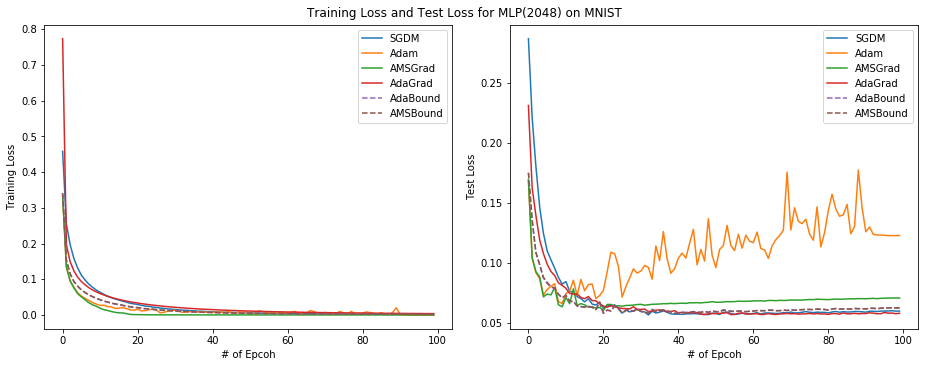

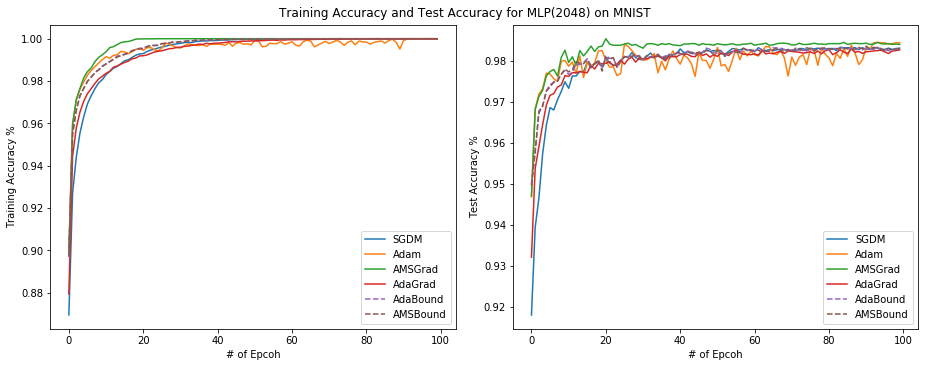

In [6]:
hidden_sizes = [2048]

for h_size in hidden_sizes:
    Stat = namedtuple('Stat', ['losses', 'accs'])
    train_results = {}
    test_results = {}   
    for optim_name, optim_config in optim_configs.items():
        torch.manual_seed(0)
        np.random.seed(0)
        train_results[optim_name] = Stat(losses=[], accs=[])
        test_results[optim_name] = Stat(losses=[], accs=[])
        net = MLP(hidden_size=h_size).to(device)
        optimizer = optim_config['optimizer'](net.parameters(), **optim_config['kwargs'])
        print(optimizer)

        for epoch in tqdm(range(100)):  # loop over the dataset multiple times
            train_stat = {
                'loss': .0,
                'correct': 0,
                'total': 0
            }

            test_stat = {
                'loss': .0,
                'correct': 0,
                'total': 0
            }
            for i, data in enumerate(trainloader, 0):
                # get the inputs
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).sum()

                # calculate
                train_stat['loss'] += loss.item()
                train_stat['correct'] += c.item()
                train_stat['total'] += labels.size()[0]
            train_results[optim_name].losses.append(train_stat['loss'] / (i + 1))
            train_results[optim_name].accs.append(train_stat['correct'] / train_stat['total'])


            with torch.no_grad():
                for i, data in enumerate(testloader, 0):
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    c = (predicted == labels).sum()

                    test_stat['loss'] += loss.item()
                    test_stat['correct'] += c.item()
                    test_stat['total'] += labels.size()[0]
                test_results[optim_name].losses.append(test_stat['loss'] / (i + 1))
                test_results[optim_name].accs.append(test_stat['correct'] / test_stat['total'])
                
    # Save stat!
    stat = {
        'train': train_results,
        'test': test_results
    }
    with open(f'best_hparam_stat_mlp_{h_size}.pkl', 'wb') as f:
        pickle.dump(stat, f)

In [7]:
from collections import namedtuple

Stat = namedtuple('Stat', ['losses', 'accs'])

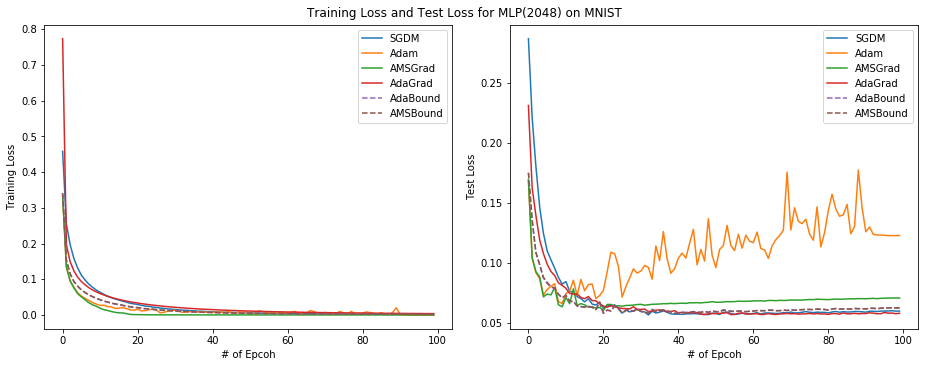

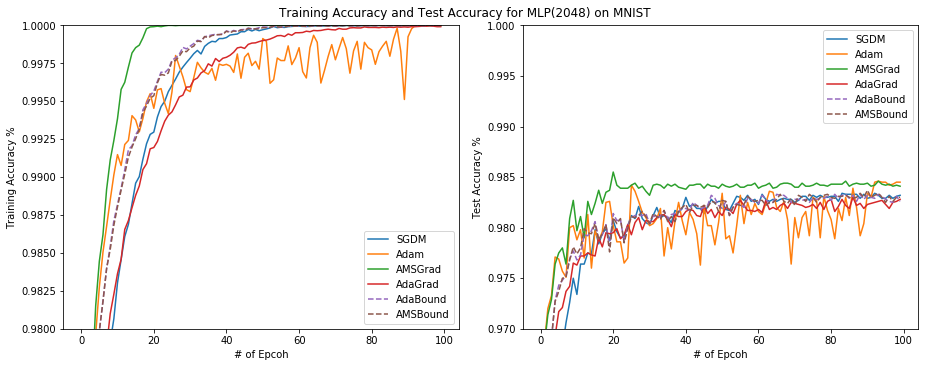

In [8]:
h_size = 2048
with open(f'best_hparam_stat_mlp_2048.pkl', 'rb') as f:
    stat = pickle.load(f)

train_results = stat['train']
test_results = stat['test']
    
# Plot loss            
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
for optim_name in optim_configs:
    if 'Bound' in optim_name:
        ax1.plot(train_results[optim_name].losses, '--', label=optim_name)
    else:
        ax1.plot(train_results[optim_name].losses, label=optim_name)
ax1.set_ylabel('Training Loss')
ax1.set_xlabel('# of Epcoh')
# ax1.set_ylim(0.95, 1)
ax1.legend()

for optim_name in optim_configs:
    if 'Bound' in optim_name:
        ax2.plot(test_results[optim_name].losses, '--', label=optim_name)
    else:
        ax2.plot(test_results[optim_name].losses, label=optim_name)
ax2.set_ylabel('Test Loss')
ax2.set_xlabel('# of Epcoh')
# ax2.set_ylim(0.925, 1)
ax2.legend()

plt.suptitle(f'Training Loss and Test Loss for MLP({h_size}) on MNIST', y=1.01)
plt.tight_layout()

# Plot accuracy 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
for optim_name in optim_configs:
    if 'Bound' in optim_name:
        ax1.plot(train_results[optim_name].accs, '--', label=optim_name)
    else:
        ax1.plot(train_results[optim_name].accs, label=optim_name)
ax1.set_ylabel('Training Accuracy %')
ax1.set_xlabel('# of Epcoh')
ax1.set_ylim(0.98, 1)
ax1.legend()

for optim_name in optim_configs:
    if 'Bound' in optim_name:
        ax2.plot(test_results[optim_name].accs, '--', label=optim_name)
    else:
        ax2.plot(test_results[optim_name].accs, label=optim_name)
ax2.set_ylabel('Test Accuracy %')
ax2.set_xlabel('# of Epcoh')
ax2.set_ylim(0.97, 1)
ax2.legend()

plt.suptitle(f'Training Accuracy and Test Accuracy for MLP({h_size}) on MNIST', y=1.01)
plt.tight_layout()
plt.show()